In [1]:
import pandas as pd
import numpy as np
import torch
import keras
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import MultilabelF1Score
from keras.preprocessing import image
from matplotlib import pyplot as plt

import cv2
import os
from nltk import wordpunct_tokenize
import re
import warnings


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('INFO')

# Data

In [3]:
# You need extract file ml1m.zip to folder ml1m before run code

users = pd.read_csv('ml1m/content/dataset/users.dat', sep='::',
                        engine='python',
                        names=['userid', 'gender', 'age', 'occupation', 'zip']).set_index('userid')
ratings = pd.read_csv('ml1m/content/dataset/ratings.dat', engine='python',
                          sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])
movies_train = pd.read_csv('ml1m/content/dataset/movies_train.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='ISO-8859-1', index_col=False).set_index('movieid')
movies_test = pd.read_csv('ml1m/content/dataset/movies_test.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='ISO-8859-1', index_col=False).set_index('movieid')
movies_train['genre'] = movies_train.genre.str.split('|')
movies_train.index.name = 'ID'
movies_test['genre'] = movies_test.genre.str.split('|')
movies_test.index.name = 'ID'

users.age = users.age.astype('int')
users.gender = users.gender.astype('category')
users.occupation = users.occupation.astype('category')
ratings.movieid = ratings.movieid.astype('int')
ratings.userid = ratings.userid.astype('int')

In [4]:
with open('ml1m/content/dataset/genres.txt', 'r') as f:
    genre_all = f.readlines()
genres = [genre.strip() for genre in genre_all]
genres

['Crime',
 'Thriller',
 'Fantasy',
 'Horror',
 'Sci-Fi',
 'Comedy',
 'Documentary',
 'Adventure',
 'Film-Noir',
 'Animation',
 'Romance',
 'Drama',
 'Western',
 'Musical',
 'Action',
 'Mystery',
 'War',
 "Children's"]

In [5]:
def preprocess(df, path='ml1m/content/dataset/ml1m-images', genres=genres) -> pd.DataFrame:
    df['img_path'] = df.apply(lambda x: os.path.join(path, str(x.name) + '.jpg'), axis=1)

    # multi-hot encoding
    for genre in genres:
        df[genre] = df.genre.apply(lambda x: 1 if genre in x else 0)
    df.drop(columns=['genre'], inplace=True)

    # Remove movies without images
    df = df[df.img_path.apply(lambda x: os.path.exists(x))]

    return df

In [6]:
trainset = preprocess(movies_train)
testset = preprocess(movies_test)

In [7]:
def vectorize(df) -> (list, list):
    x = []
    for i in tqdm(range(len(df))):
        img = image.load_img(df.iloc[i].img_path, target_size=(224, 224, 3))
        img = image.img_to_array(img)
        img = img / 255
        x.append(img)
    y = df[genres].values
    return x, y

In [8]:
x_train, y_train = vectorize(trainset)
x_test, y_test = vectorize(testset)

  0%|          | 0/2602 [00:00<?, ?it/s]

100%|██████████| 654/654 [00:08<00:00, 79.61it/s]


## Model

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
conv_base = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_base.trainable = True

model = keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(18, activation='softmax'))

In [11]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model._name = 'Poro'

Epoch 1/20


74/74 [==============================] - 598s 8s/step - loss: 0.3439 - accuracy: 0.1884 - val_loss: 0.2741 - val_accuracy: 0.2912
Epoch 2/20
74/74 [==============================] - 527s 7s/step - loss: 0.3060 - accuracy: 0.2379 - val_loss: 0.2733 - val_accuracy: 0.2797
Epoch 3/20
74/74 [==============================] - 528s 7s/step - loss: 0.2946 - accuracy: 0.2439 - val_loss: 0.2647 - val_accuracy: 0.3333
Epoch 4/20
74/74 [==============================] - 572s 8s/step - loss: 0.2891 - accuracy: 0.2589 - val_loss: 0.2767 - val_accuracy: 0.3257
Epoch 5/20
74/74 [==============================] - 638s 9s/step - loss: 0.2817 - accuracy: 0.2853 - val_loss: 0.2611 - val_accuracy: 0.3333
Epoch 6/20
74/74 [==============================] - 618s 8s/step - loss: 0.2750 - accuracy: 0.2871 - val_loss: 0.2651 - val_accuracy: 0.3448
Epoch 7/20
74/74 [==============================] - 634s 9s/step - loss: 0.2678 - accuracy: 0.3178 - val_loss: 0.2618 - val_accuracy: 0.3218
Epoch 8/20


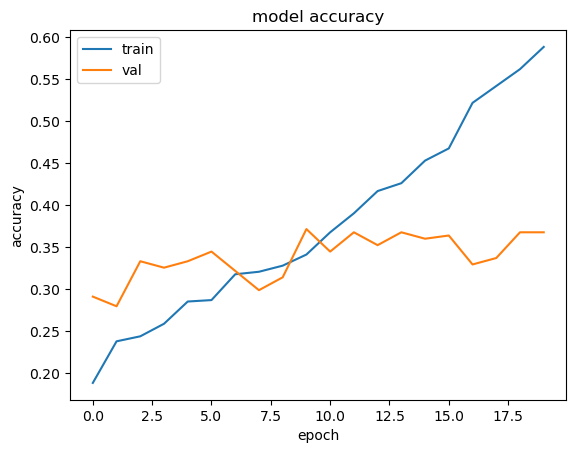

In [12]:
# If trainable = True, run this cell
if conv_base.trainable:
    history = model.fit(np.array(x_train), np.array(y_train), epochs=20, batch_size=32, validation_split=0.1, workers=4)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

## Loss

In [13]:
# Calculate Multi-label F1 score, threshold = 0.5, average = 'macro'
y_pred = model.predict(np.array(x_test))
f1 = MultilabelF1Score(num_labels=18, threshold=0.5, average='macro')
f1.update(torch.tensor(y_pred), torch.tensor(y_test))
f1.compute()

21/21 [==============================] - 38s 2s/step


tensor(0.0900)

In [14]:
# Version: 1.0 Poro